In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [8]:
def convolve_kernels(distribution_kernels, dx):
    """
    distribution_kernels: list of kernels 
    """
    for i, distribution in enumerate(distribution_kernels):
        if i == 0:
            convolution = np.convolve(distribution, distribution_kernels[1], mode='same') * dx
        if i != 0 and i < len(distribution_kernels): 
            convolution = np.convolve(convolution, distribution, mode='same') * dx
    return convolution

In [9]:
def delta_kernel_1d(x0, intint, x, dx):
    # Normalized Delta function
    y = np.zeros_like(x)  # Empty array
    temp = np.argmin(np.abs(x - x0))  # Find the closest point
    y[temp] = 1
    y = intint * y / (np.sum(y) * dx)
    return y

def tophat_kernel_1d(x0, halfwidth, intint, x, dx):
    # Normalized Tophat function
    y = np.zeros_like(x)  # Empty array
    temp = np.where((x >= x0 - halfwidth) & (x <= x0 + halfwidth))
    y[temp] = 1
    y = intint * y / (np.sum(y) * dx)
    return y

def triangle_kernel_1d(x0, basehalfwidth, intint, x, dx):
    # Normalized Triangle function
    y = np.zeros_like(x)  # Empty array
    temp = np.where((x >= x0 - basehalfwidth) & (x <= x0 + basehalfwidth))
    y[temp] = 1 - (1 / basehalfwidth) * np.abs(x[temp] - x0)
    y = intint * y / (np.sum(y) * dx)
    return y

def circle_kernel_1d(x0, radius, intint, x, dx):
    # Normalized Tophat function
    y = np.zeros_like(x)  # Empty array
    temp = np.where((x >= (x0 - radius)) & (x <= (x0 + radius)))
    y[temp] = np.sqrt(radius**2 - (x[temp] - x0)**2)
    y = intint * y / (np.sum(y) * dx)
    return y

In [19]:
def get_aperture_smearing(l2, l_collimation, r1, r2):
      
    inv_l3 = (l_collimation + l2) / (l_collimation * l2)
    
    # Terms in Mildner and Carpenter equation.
    # See https://docs.mantidproject.org/nightly/algorithms/TOFSANSResolutionByPixel-v1.html
    a1 = (r1/l_collimation)*(r1/l_collimation) * 3.0
    a2 = (r2*inv_l3)*(r2*inv_l3) * 3.0

    aperture_smearing = (4.0 * np.pi / 12) * (a1 + a2) 
    return aperture_smearing

In [12]:
def get_detector_pixelation(dr, l2):
    
    a3 = (dr/l2) * (dr/l2) 
    return a3

In [38]:
x0 = 0.0
intint = 1.0
x_values = np.linspace(-20, 20, 1000)
dx = x_values[1] - x_values[0]

delta_distribution = delta_kernel_1d(x0, intint, x_values, dx)

# halfwidth = 2.0
# binning_smearing = tophat_kernel_1d(x0, halfwidth, intint, x_values, dx)

halfwidth = 3.4 * get_aperture_smearing(l2, l_collimation, r1, r2)
print(halfwidth)
sample_aperture_smearing = tophat_kernel_1d(x0, halfwidth, intint, x_values, dx)

halfwidth = 3.4 * get_detector_pixelation(dr, l2)
detector_pixelation = tophat_kernel_1d(x0, halfwidth, intint, x_values, dx)

halfwidth = 2.0 * halfwidth 
binning_smearing = tophat_kernel_1d(x0, halfwidth, intint, x_values, dx)

#Needs to be read from the Moderator file. Do it per wavelength
#For testing purpsoses whatever comes for wavelength 7.0Å
basehalfwidth = 7.877900E+01
wavelength_smearing = triangle_kernel_1d(x0, basehalfwidth, intint, x_values, dx)

#radius = 2.0
#geometric_divergence = circle_kernel_1d(x0, radius, intint, x_values, dx)

#distribution_kernels = [geometric_divergence, sample_aperture_smearing, detector_pixelation, binning_resolution, wavelength_resolution]

distribution_kernels = [sample_aperture_smearing, detector_pixelation, binning_smearing, wavelength_smearing]

9.642944117268672e-05


/var/folders/3h/75v0nlln0l5bj3dkh_dmtrrc0000gq/T/ipykernel_642/4111944504.py:14: RuntimeWarning: invalid value encountered in divide
  y = intint * y / (np.sum(y) * dx)


In [33]:
# l_collimation = 4.0*sc.units.m
# r2 = 0.004*sc.units.m
# r1 = 0.01*sc.units.m
# dr = 0.008*sc.units.m
# l2 = 6.0*sc.unit.m

In [34]:
l_collimation = 4.0
r2 = 0.004
r1 = 0.01
dr = 0.008
l2 = 6.0

In [35]:
# path = 'SANS2D_data'
# moderator_file = 'ModeratorStdDev_TS2_SANS_LETexptl_07Aug2015.txt'
# moderator = loki.io.load_rkh_wav(filename=f'{path}/{moderator_file}')

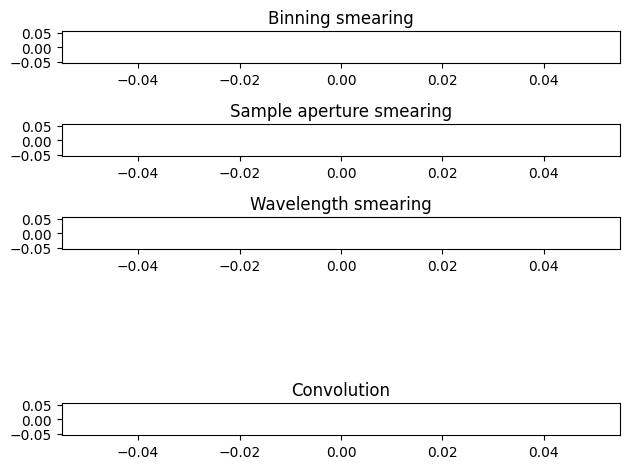

In [36]:
convolution = convolve_kernels(distribution_kernels, dx)

plt.subplot(5, 1, 1)
plt.plot(x_values, binning_smearing)
plt.title('Binning smearing')

plt.subplot(5, 1, 2)
plt.plot(x_values, sample_aperture_smearing)
plt.title('Sample aperture smearing')


plt.subplot(5, 1, 3)
plt.plot(x_values, detector_pixelation)
plt.title('Wavelength smearing')

#plt.subplot(5, 1, 4)
#plt.plot(x_values, geometric_divergence)
#plt.title('Geomertric divergence')

plt.subplot(5, 1, 5)
plt.plot(x_values, convolution)
plt.title('Convolution')
plt.tight_layout()


#convolution = np.convolve(top_hat(x_values, a_top, b_top, c_top), triangular_distribution(x_values, a_tri, b_tri, c_tri), mode='same') * (x_values[1] - x_values[0])
plt.show()
